In [14]:
import numpy as np
import pandas as pd

def randomize_tracktemp(df_random,
                        fluctuation_std=0.3,
                        min_temp_clip=30,
                        max_temp_clip=45,
                        cooling_after_lap=None,
                        cooling_bias=-0.05):
    """
    Randomly generate realistic TrackTemp values for 78 laps.

    Parameters:
    - df_random: DataFrame containing at least 'LapNumber' and 'TrackTemp'.
    - fluctuation_std: Standard deviation of lap-to-lap temperature change (°C).
    - min_temp_clip: Minimum allowed TrackTemp (°C).
    - max_temp_clip: Maximum allowed TrackTemp (°C).
    - cooling_after_lap: If set, apply slight cooling drift after this lap.
    - cooling_bias: Mean shift for lap-to-lap fluctuation after cooling lap (°C).

    Returns:
    - tracktemp_randomized_df: DataFrame with LapNumber and randomized TrackTemp.
    """

    randomized_tracktemps = []

    # Step 1: Pick Lap 1
    lap1_data = df_random[df_random['LapNumber'] == 1]['TrackTemp']
    lap1_temp = lap1_data.sample(n=1, random_state=np.random.randint(10000)).values[0]
    randomized_tracktemps.append(lap1_temp)

    # Step 2: Generate laps 2–78
    for lap in range(2, 79):
        prev_temp = randomized_tracktemps[-1]

        if cooling_after_lap is not None and lap > cooling_after_lap:
            fluctuation = np.random.normal(loc=cooling_bias, scale=fluctuation_std)
        else:
            fluctuation = np.random.normal(loc=0, scale=fluctuation_std)

        new_temp = prev_temp + fluctuation
        new_temp = np.clip(new_temp, min_temp_clip, max_temp_clip)

        randomized_tracktemps.append(new_temp)

    # Assemble final DataFrame
    tracktemp_randomized_df = pd.DataFrame({
        'LapNumber': np.arange(1, 79),
        'TrackTemp': randomized_tracktemps
    })

    return tracktemp_randomized_df

def generate_weight_per_lap(car_type='V10'):
    """
    Generate a dataframe of Weight per LapNumber for a given car type.

    Args:
    - car_type: String, either 'V6' or 'V10'

    Returns:
    - weight_df: DataFrame with columns ['LapNumber', 'Weight']
    """

    # Define base weights for each car type
    base_weights = {
        'V6': 798,   # Base weight for V6 hybrid car (without fuel)
        'V10': 783   # Base weight for V10 hybrid car (without fuel)
    }

    # Normalize car_type input
    car_type = car_type.upper()

    # Validate input
    if car_type not in base_weights:
        raise ValueError("car_type must be 'V6' or 'V10'")

    base_weight = base_weights[car_type]

    # Constants
    laps_total = 78
    fuel_start_min = 100
    fuel_start_max = 110
    fuel_end_min = 1
    fuel_end_max = 2

    # Generate randomized fuel values
    initial_fuel = np.random.uniform(fuel_start_min, fuel_start_max)
    final_fuel = np.random.uniform(fuel_end_min, fuel_end_max)
    burn_per_lap = (initial_fuel - final_fuel) / (laps_total - 1)

    # Generate weight per lap
    weights = []
    for lap in range(1, laps_total + 1):
        current_fuel = initial_fuel - (lap - 1) * burn_per_lap
        current_weight = base_weight + current_fuel
        weights.append((lap, current_weight))

    # Return DataFrame
    weight_df = pd.DataFrame(weights, columns=['LapNumber', 'Weight'])
    return weight_df

def generate_trackstatus_per_lap():
    """
    Generate a DataFrame with randomized TrackStatus per LapNumber for 78 laps.

    Returns:
    - trackstatus_df: DataFrame with columns ['LapNumber', 'TrackStatus']
    """

    # Constants
    laps_total = 78
    trackstatus_choices = [0, 1, 2, 3]  # 0: AC, 1: YF, 2: VSC, 3: SC
    probabilities = [0.8957, 0.0762, 0.0064, 0.0217]  # From your EDA

    # Randomly choose one status per lap
    trackstatus_list = np.random.choice(trackstatus_choices, size=laps_total, p=probabilities)

    # Create dataframe
    trackstatus_df = pd.DataFrame({
        'LapNumber': np.arange(1, laps_total + 1),
        'TrackStatus': trackstatus_list
    })

    return trackstatus_df

import pandas as pd
import numpy as np

def generate_throttle_rpm_per_lap(df_random, car_type='V10', transition_throttle=60):
    """
    Generate a dataframe with randomized Throttle and calculated RPM per lap
    for either V6 or V10 engine type.

    Args:
    - df_random: Input DataFrame with 'LapNumber' and 'Throttle' columns
    - car_type: 'V6' or 'V10'
    - transition_throttle: Throttle % at which model switches between quadratic and linear

    Returns:
    - result_df: DataFrame with ['LapNumber', 'Throttle', 'RPM']
    """

    # Normalize input
    car_type = car_type.upper()

    # Constants
    laps_total = 78

    # Coefficients from piecewise regression model
    # For Throttle ≤ transition_throttle (Quadratic)
    quad_intercept = 3497.86
    quad_coef1 = 219.56
    quad_coef2 = -2.03

    # For Throttle > transition_throttle (Linear)
    lin_intercept = 7224.98
    lin_coef = -72.24

    lap_results = []

    for lap in range(1, laps_total + 1):
        lap_data = df_random[df_random['LapNumber'] == lap]

        if lap_data.empty:
            continue

        sampled_throttle = lap_data['Throttle'].sample(n=1).values[0]

        # Predict RPM based on throttle
        if sampled_throttle <= transition_throttle:
            rpm = (quad_intercept
                   + quad_coef1 * sampled_throttle
                   + quad_coef2 * sampled_throttle**2)
        else:
            rpm = lin_intercept + lin_coef * sampled_throttle

        # Scale only if V10
        if car_type == 'V10':
            rpm *= (20000 / 15000)  # Scale up by 1.333...

        lap_results.append((lap, sampled_throttle, rpm))

    result_df = pd.DataFrame(lap_results, columns=['LapNumber', 'Throttle', 'RPM'])

    return result_df


def generate_full_lap_data(laps, df_random, car_type):
    """
    Generates a full dataset per lap by combining fixed variables (laps) with
    randomized TrackTemp, Weight, TrackStatus, Throttle, and RPM.

    Args:
    - laps: DataFrame containing fixed variables and 'LapNumber'.
    - df_random: DataFrame containing random pool for throttle (must have 'LapNumber' and 'Throttle').

    Returns:
    - final_df: DataFrame with all fixed and random variables combined, LapNumber dropped.
    """

    # 1. Generate random variables
    tracktemp_df = randomize_tracktemp(df_random)
    weight_df = generate_weight_per_lap(car_type)
    trackstatus_df = generate_trackstatus_per_lap()
    throttle_rpm_df = generate_throttle_rpm_per_lap(df_random,car_type)

    # 2. Merge everything on 'LapNumber'
    merged_df = laps.merge(tracktemp_df, on='LapNumber', how='left')
    merged_df = merged_df.merge(weight_df, on='LapNumber', how='left')
    merged_df = merged_df.merge(trackstatus_df, on='LapNumber', how='left')
    merged_df = merged_df.merge(throttle_rpm_df, on='LapNumber', how='left')

    # 3. Drop LapNumber
    merged_df = merged_df.drop(columns=['LapNumber'])

    return merged_df




In [15]:
df_source = pd.read_csv('regression_mc_sim.csv')

In [16]:
df_source[df_source['LapNumber']==23]

,LapNumber,TrackTemp,RPM,Throttle,Brake,DRS,LapTime,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Weight,PitDuration
22,23.0,34.3,9566.787879,51.506061,81,0,78.431,1,1.0,27.0,0,0,809.061557,0.0
100,23.0,34.3,9537.425000,47.009375,97,0,78.373,1,3.0,2.0,1,0,808.073223,0.0
178,23.0,34.3,9216.135952,44.595166,99,0,77.018,1,3.0,4.0,1,0,807.905372,0.0
230,23.0,34.3,9454.107034,49.639144,99,18,78.184,0,3.0,9.0,1,0,807.815128,0.0
300,23.0,34.3,9234.946108,43.161677,110,0,83.528,0,3.0,15.0,0,0,809.418369,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7941,23.0,46.3,9128.176667,43.920000,75,16,80.662,1,6.0,23.0,0,0,876.685653,0.0
8016,23.0,46.3,8516.153333,41.173333,97,15,80.750,0,6.0,9.0,0,0,875.091548,0.0
8091,23.0,46.3,8915.910891,39.920792,78,0,81.188,0,5.0,23.0,0,0,872.698964,0.0
8166,23.0,46.3,9112.856667,40.130000,88,20,80.593,1,6.0,23.0,0,0,870.899698,0.0


In [17]:
def create_fixed_variables():
    laps = pd.DataFrame({'LapNumber': range(1, 79)})

    # ---- Step 2: Aggregate fixed variables from source ----
    agg_fixed = df_source.groupby('LapNumber').agg({
        'Throttle': 'mean',
        'Brake': 'mean',
        'DRS': 'mean'
    }).reset_index()

    # Round Throttle, Brake, DRS to integers
    agg_fixed['Brake'] = agg_fixed['Brake'].round().astype(int)
    agg_fixed['DRS'] = agg_fixed['DRS'].round().astype(int)

    # Merge into the lap DataFrame
    laps = laps.merge(agg_fixed, on='LapNumber', how='left')

    # ---- Step 3: Pit Duration ----
    # Average of nonzero pit_durations
    avg_pit_duration = df_source[df_source['PitDuration'] > 0]['PitDuration'].mean()

    # Assign pit_duration
    laps['PitDuration'] = 0.0
    laps.loc[laps['LapNumber'] == 32, 'PitDuration'] = avg_pit_duration

    # ---- Step 4: Compound ----
    laps['Compound'] = np.where(laps['LapNumber'] <= 31, 5, 6)

    # ---- Step 5: Tyre Life ----
    laps['TyreLife'] = np.where(
        laps['LapNumber'] <= 31,
        laps['LapNumber'],                   # Laps 1–31
        laps['LapNumber'] - 31                # Restart count from 1 after pit stop
    )
    laps.to_csv('MC_Fixed_data.csv', index=False)
    return laps

In [18]:
#laps = create_fixed_variables()
laps = pd.read_csv('MC_Fixed_data.csv')
laps

,LapNumber,Throttle,Brake,DRS,PitDuration,Compound,TyreLife
0,1,40.101048,112,0,0.0,5,1
1,2,41.665370,102,5,0.0,5,2
2,3,41.956385,98,7,0.0,5,3
3,4,42.088928,97,7,0.0,5,4
4,5,42.470642,98,5,0.0,5,5
...,...,...,...,...,...,...,...
73,74,45.910959,91,4,0.0,6,43
74,75,44.908604,91,4,0.0,6,44
75,76,42.370703,104,3,0.0,6,45
76,77,36.147459,128,3,0.0,6,46


In [19]:
df_source

,LapNumber,TrackTemp,RPM,Throttle,Brake,DRS,LapTime,IsPersonalBest,Compound,TyreLife,FreshTyre,TrackStatus,Weight,PitDuration
0,1.0,33.75,9531.494048,46.101190,99,0,91.614,0,6.0,20.0,1,1,838.471950,0.0
1,2.0,33.90,9394.374251,47.080838,93,16,80.619,1,1.0,6.0,0,1,837.135114,0.0
2,3.0,33.90,9429.505952,48.086310,89,24,79.812,1,1.0,7.0,0,0,835.798278,0.0
3,4.0,33.90,9437.838906,47.723404,85,22,79.562,1,1.0,8.0,0,0,834.461442,0.0
4,5.0,33.60,9427.572727,46.830303,92,19,79.400,1,1.0,9.0,0,0,833.124606,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8290,72.0,40.50,9382.875887,50.872340,90,0,80.585,0,4.0,2.0,1,0,807.296677,0.0
8291,73.0,40.80,8971.025559,43.853035,102,0,75.233,1,4.0,3.0,1,0,805.967166,0.0
8292,74.0,40.80,9461.837545,52.931408,85,0,80.473,0,4.0,4.0,1,0,804.637655,0.0
8293,75.0,40.60,9103.670175,47.568421,88,0,74.718,1,4.0,5.0,1,0,803.308144,0.0


In [20]:
df_random = df_source[['LapNumber','TrackTemp','Weight','TrackStatus','Throttle','RPM']]
df_random

,LapNumber,TrackTemp,Weight,TrackStatus,Throttle,RPM
0,1.0,33.75,838.471950,1,46.101190,9531.494048
1,2.0,33.90,837.135114,1,47.080838,9394.374251
2,3.0,33.90,835.798278,0,48.086310,9429.505952
3,4.0,33.90,834.461442,0,47.723404,9437.838906
4,5.0,33.60,833.124606,0,46.830303,9427.572727
...,...,...,...,...,...,...
8290,72.0,40.50,807.296677,0,50.872340,9382.875887
8291,73.0,40.80,805.967166,0,43.853035,8971.025559
8292,74.0,40.80,804.637655,0,52.931408,9461.837545
8293,75.0,40.60,803.308144,0,47.568421,9103.670175


             min    max       mean       std
LapNumber                                   
1.0        29.10  43.15  36.604545  5.538221
2.0        28.70  49.20  37.543925  6.386309
3.0        28.70  49.20  38.195652  6.768702
4.0        28.50  48.50  37.993913  6.613321
5.0        28.45  48.20  37.873913  6.519183
...          ...    ...        ...       ...
74.0       30.00  40.80  33.655682  3.821863
75.0       30.35  40.60  33.577273  3.647310
76.0       30.70  40.75  33.733721  3.625031
77.0       30.70  40.90  33.648649  3.328138
78.0       30.62  40.25  33.841522  3.211998

[78 rows x 4 columns]


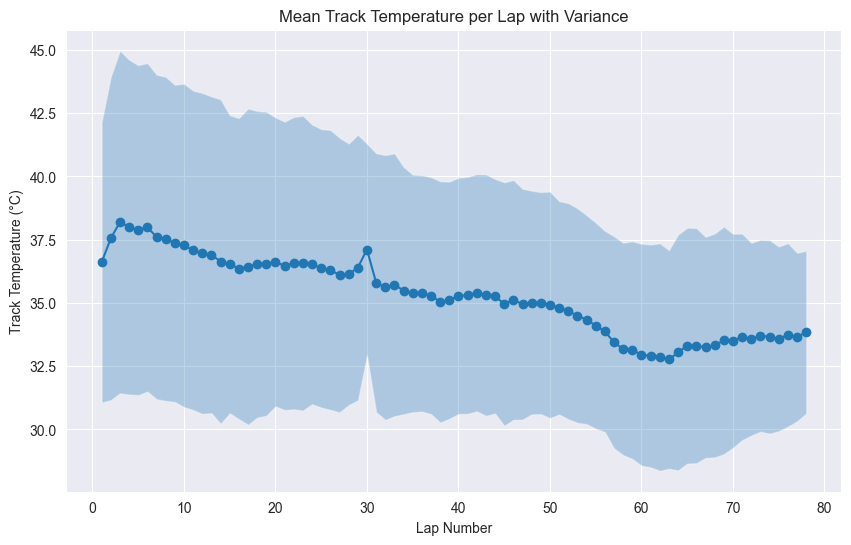

In [21]:
# Let's first explore the TrackTemp values
tracktemp_stats = df_random.groupby('LapNumber')['TrackTemp'].agg(['min', 'max', 'mean', 'std'])

# Print basic statistics
print(tracktemp_stats)

# Plot mean TrackTemp per lap
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.plot(tracktemp_stats.index, tracktemp_stats['mean'], marker='o')
plt.fill_between(tracktemp_stats.index,
                 tracktemp_stats['mean'] - tracktemp_stats['std'],
                 tracktemp_stats['mean'] + tracktemp_stats['std'],
                 alpha=0.3)
plt.xlabel('Lap Number')
plt.ylabel('Track Temperature (°C)')
plt.title('Mean Track Temperature per Lap with Variance')
plt.grid(True)
plt.show()


In [22]:
# Call the function
tracktemp_randomized_df = randomize_tracktemp(
    df_random,
    fluctuation_std=0.3,
    min_temp_clip=30,
    max_temp_clip=45,
    cooling_after_lap=30,  # Start slight cooling after lap 30
    cooling_bias=-0.05     # Slight downward trend after lap 30
)

# View
print(tracktemp_randomized_df)

# Optional: Save
#tracktemp_randomized_df.to_csv('MC_TrackTemp_randomized.csv', index=False)


    LapNumber  TrackTemp
0           1  34.400000
1           2  34.372542
2           3  34.024288
3           4  34.406169
4           5  34.425566
..        ...        ...
73         74  34.502746
74         75  34.908121
75         76  35.036836
76         77  34.990244
77         78  34.846835

[78 rows x 2 columns]


In [23]:
# Example usage:
# For V10 Hybrid
weight_v10_df = generate_weight_per_lap()

# View
weight_v10_df

,LapNumber,Weight
0,1,890.082517
1,2,888.710748
2,3,887.338978
3,4,885.967209
4,5,884.595439
...,...,...
73,74,789.943346
74,75,788.571577
75,76,787.199807
76,77,785.828038


Overall TrackStatus value counts:
TrackStatus
0    89.572031
1     7.619048
3     2.169982
2     0.638939
Name: proportion, dtype: float64


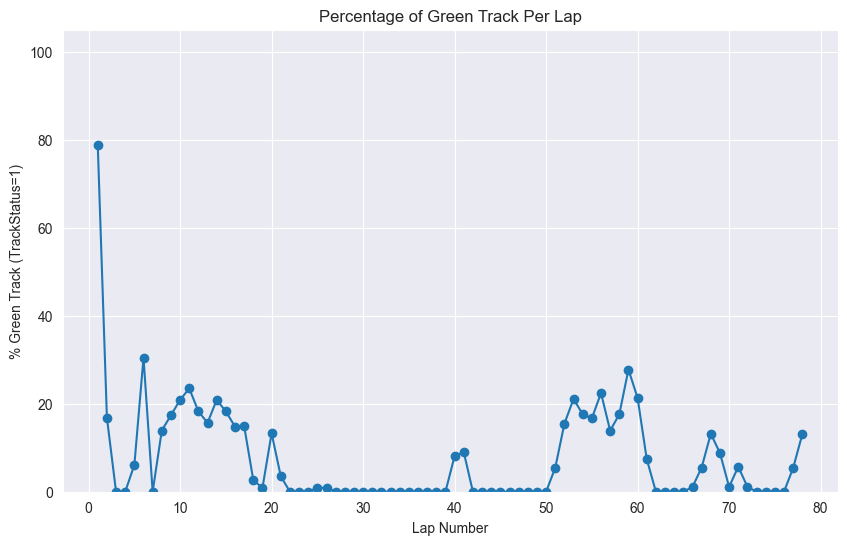


Laps with significant non-green track activity:
LapNumber
1.0     78.787879
2.0     16.822430
3.0      0.000000
4.0      0.000000
5.0      6.086957
          ...    
74.0     0.000000
75.0     0.000000
76.0     0.000000
77.0     5.405405
78.0    13.043478
Name: TrackStatus, Length: 78, dtype: float64


In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your random variable df is already loaded as df_random

# Step 1: Overall Value Counts
print("Overall TrackStatus value counts:")
print(df_random['TrackStatus'].value_counts(normalize=True) * 100)  # % distribution

# Step 2: Per Lap - % of green track (TrackStatus=1)
green_track_per_lap = df_random.groupby('LapNumber')['TrackStatus'].apply(lambda x: (x == 1).mean() * 100)

# Step 3: Plot % of green track per lap
plt.figure(figsize=(10,6))
plt.plot(green_track_per_lap.index, green_track_per_lap.values, marker='o')
plt.xlabel('Lap Number')
plt.ylabel('% Green Track (TrackStatus=1)')
plt.title('Percentage of Green Track Per Lap')
plt.ylim(0, 105)
plt.grid(True)
plt.show()

# Step 4 (Optional): Identify laps where green track % drops
laps_with_incidents = green_track_per_lap[green_track_per_lap < 90]
print("\nLaps with significant non-green track activity:")
print(laps_with_incidents)


In [25]:
# Generate TrackStatus list
trackstatus_list = generate_trackstatus_per_lap()

# View first few
trackstatus_list  # Example output: [0, 0, 1, 0, 0, 0, 0, 3, 0, 0]


,LapNumber,TrackStatus
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
...,...,...
73,74,0
74,75,1
75,76,0
76,77,0


In [26]:
# Example usage:

# Suppose your df_random is already loaded
throttle_rpm_df = generate_throttle_rpm_per_lap(df_random)

# View
throttle_rpm_df


,LapNumber,Throttle,RPM
0,1,49.176292,12514.456062
1,2,25.258145,10331.268486
2,3,37.657738,11849.652456
3,4,42.975684,12245.833415
4,5,28.901919,10863.818482
...,...,...,...
73,74,50.201893,12538.827466
74,75,36.844118,11775.535720
75,76,48.057402,12481.373317
76,77,47.624606,12466.758932


In [27]:
laps

,LapNumber,Throttle,Brake,DRS,PitDuration,Compound,TyreLife
0,1,40.101048,112,0,0.0,5,1
1,2,41.665370,102,5,0.0,5,2
2,3,41.956385,98,7,0.0,5,3
3,4,42.088928,97,7,0.0,5,4
4,5,42.470642,98,5,0.0,5,5
...,...,...,...,...,...,...,...
73,74,45.910959,91,4,0.0,6,43
74,75,44.908604,91,4,0.0,6,44
75,76,42.370703,104,3,0.0,6,45
76,77,36.147459,128,3,0.0,6,46


In [28]:
laps.drop('Throttle', axis=1, inplace=True)

In [29]:
laps

,LapNumber,Brake,DRS,PitDuration,Compound,TyreLife
0,1,112,0,0.0,5,1
1,2,102,5,0.0,5,2
2,3,98,7,0.0,5,3
3,4,97,7,0.0,5,4
4,5,98,5,0.0,5,5
...,...,...,...,...,...,...
73,74,91,4,0.0,6,43
74,75,91,4,0.0,6,44
75,76,104,3,0.0,6,45
76,77,128,3,0.0,6,46


In [30]:
# Assuming you have:
# - laps dataframe with fixed variables
# - df_random dataframe with throttle pool

final_lap_data = generate_full_lap_data(laps, df_random, car_type='v10')

# View
final_lap_data


,Brake,DRS,PitDuration,Compound,TyreLife,TrackTemp,Weight,TrackStatus,Throttle,RPM
0,112,0,0.0,5,1,33.750000,887.416481,3,44.417160,12326.849216
1,102,5,0.0,5,2,33.610635,886.083021,0,40.835821,12104.823162
2,98,7,0.0,5,3,33.584924,884.749561,0,46.274143,12414.639115
3,97,7,0.0,5,4,33.346405,883.416101,0,40.068862,12048.248722
4,98,5,0.0,5,5,33.754635,882.082641,0,44.496528,12330.983254
...,...,...,...,...,...,...,...,...,...,...
73,91,4,0.0,6,43,37.424055,790.073910,0,43.189759,12258.576352
74,91,4,0.0,6,44,37.583812,788.740450,0,49.217910,12515.555892
75,104,3,0.0,6,45,37.492597,787.406990,0,29.200466,10904.266519
76,128,3,0.0,6,46,37.169393,786.073530,0,43.575851,12280.931517


In [31]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

def train_random_forest(df):
    """
    Train a simple Random Forest Regressor on the given dataframe without hyperparameter tuning.

    Args:
    - df: Input DataFrame

    Returns:
    - model: Trained Random Forest model
    - metrics: Dictionary with MSE, MAE, R²
    """

    # ---- Step 1: Define features and target ----
    X = df.drop(['LapTime', 'FreshTyre', 'IsPersonalBest'], axis=1)
    y = df["LapTime"]

    # ---- Step 2: Train/test split ----
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # ---- Step 3: Train Random Forest Regressor ----
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # ---- Step 4: Predict and evaluate ----
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Random Forest Regression Results:")
    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")
    print(f"R² Score: {r2:.4f}")

    metrics = {
        'MSE': mse,
        'MAE': mae,
        'R2': r2
    }

    return model, metrics, X


In [32]:
# Suppose df is your final MC simulation dataframe
df_regression = pd.read_csv('regression_final.csv')
best_model, metrics, X = train_random_forest(df_regression)

# Access best_model.predict() later to predict new lap times!


Random Forest Regression Results:
Mean Squared Error (MSE): 10.84
Mean Absolute Error (MAE): 1.27
R² Score: 0.9078


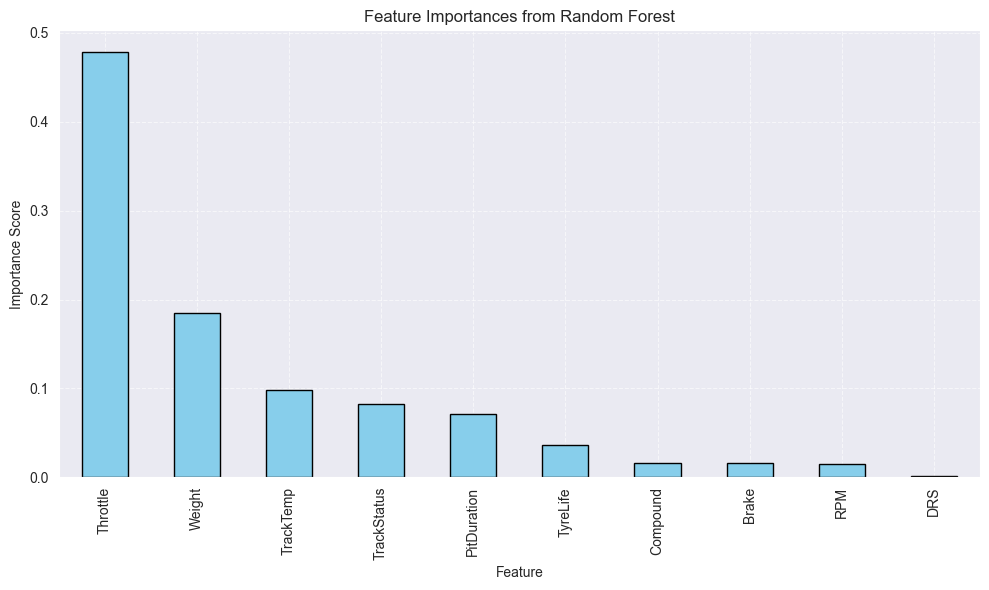

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming you have:
# - model: your trained RandomForestRegressor
# - X: the training feature matrix (or use df.drop([...], axis=1) again)

# Step 1: Extract importances and pair with column names
feature_importances = pd.Series(best_model.feature_importances_, index=X.columns)

# Step 2: Sort by importance (descending)
feature_importances = feature_importances.sort_values(ascending=False)

# Step 3: Plot
plt.figure(figsize=(10, 6))
feature_importances.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Feature Importances from Random Forest')
plt.ylabel('Importance Score')
plt.xlabel('Feature')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [34]:
def monte_carlo_simulation(model, laps, df_random, car_type, n_simulations=5000):
    """
    Run Monte Carlo simulations to predict race times and output a DataFrame.

    Args:
    - model: Trained Random Forest model
    - laps: DataFrame with fixed variables (must include 'LapNumber')
    - df_random: DataFrame with random pool for throttle and tracktemp generation
    - n_simulations: Number of Monte Carlo simulations to run (default=5000)

    Returns:
    - race_times_df: DataFrame with columns ['SimulationNumber', 'RaceTime']
    """

    simulation_numbers = []
    race_times = []

    for sim in range(1, n_simulations + 1):
        # Step 1: Generate a new randomized lap dataset
        sim_df = generate_full_lap_data(laps.copy(), df_random, car_type)

        correct_feature_order = [
        'TrackTemp', 'RPM', 'Throttle', 'Brake', 'DRS',
        'Compound', 'TyreLife', 'TrackStatus', 'Weight', 'PitDuration'
        ]
        sim_df = sim_df[correct_feature_order]
        # Step 2: Predict lap times
        lap_times = model.predict(sim_df)

        # Step 3: Sum up all 78 lap times to get total race time
        total_race_time = np.sum(lap_times)

        # Step 4: Store the simulation number and race time
        simulation_numbers.append(sim)
        race_times.append(total_race_time)

    # Create DataFrame
    race_times_df = pd.DataFrame({
        'SimulationNumber': simulation_numbers,
        'RaceTime': race_times
    })

    return race_times_df


In [35]:
# Example usage:

# Run the simulation
race_times_df_v10 = monte_carlo_simulation(best_model, laps, df_random, n_simulations=5000, car_type='v10')
race_times_df_v6 = monte_carlo_simulation(best_model, laps, df_random, n_simulations=5000, car_type='v6')
# View



In [36]:
race_times_df_v10

,SimulationNumber,RaceTime
0,1,6405.33507
1,2,6396.03859
2,3,6444.40953
3,4,6500.58992
4,5,6330.71293
...,...,...
4995,4996,6440.54275
4996,4997,6349.48258
4997,4998,6411.49204
4998,4999,6308.91177


In [37]:
race_times_df_v6

,SimulationNumber,RaceTime
0,1,6452.30887
1,2,6498.61756
2,3,6473.71293
3,4,6457.45168
4,5,6399.47963
...,...,...
4995,4996,6380.10905
4996,4997,6553.03732
4997,4998,6399.93247
4998,4999,6421.26241


In [38]:
race_times_df_v6.to_csv('race_times_v6.csv')
race_times_df_v10.to_csv('race_times_v10.csv')